#1. Load Data & Preprocess
I got historical VIX data from CBOE using [vix_utils](https://github.com/dougransom/vix_utils) by Doug Ransom.

In [168]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
vix_index = pd.read_pickle('drive/MyDrive/VIX/vix_index.pkl')
vix_index = vix_index.loc[(vix_index['Symbol'] == 'VIX'), ['Trade Date', 'Close']]
vix_index.rename(columns={'Close': 'Index_Price'}, inplace=True)
vix_index.set_index('Trade Date', inplace=True)
vix_index

,Index_Price
Trade Date,
1990-01-02,17.24
1990-01-03,18.19
1990-01-04,19.22
1990-01-05,20.11
1990-01-08,20.26
...,...
2023-12-21,13.65
2023-12-22,13.03
2023-12-26,12.99


In [3]:
vix_futures = pd.read_pickle('drive/MyDrive/VIX/vix_futures.pkl')
vix_futures = vix_futures[['Trade Date', 'Tenor_Monthly', 'Tenor_Days', 'Tenor_Trade_Days', 'Close']]
vix_futures.rename(columns={'Close': 'Futures_Price'}, inplace=True)
vix_futures.set_index('Trade Date', inplace=True)
vix_futures

,Tenor_Monthly,Tenor_Days,Tenor_Trade_Days,Futures_Price
Trade Date,,,,
2004-03-26,2.0,53,38.0,20.27
2004-03-26,3.0,81,56.0,20.20
2004-03-26,5.0,144,100.0,20.06
2004-03-26,8.0,236,164.0,20.89
2004-03-29,2.0,50,37.0,19.77
...,...,...,...,...
2023-12-28,4.0,110,75.0,16.91
2023-12-28,5.0,145,100.0,17.28
2023-12-28,6.0,172,118.0,17.62


#2. Modeling VIX Price as a Stochastic Process
Modeled VIX as stochastic processes below:
<br>
- Cox-Ingersoll-Ross process
$$dV_t = (\alpha - \beta{V_t})dt + \sigma\sqrt{V_t}{dW_t}$$
<br>
- Mean-Reverting Constant Elasticity of Variance process
$$dV_t = (\alpha - \beta{V_t})dt + \sigma{V_t}^\gamma{dW_t}$$
<br>
- Cox-Ingersoll-Ross process with jumps
$$dV_t = (\alpha - \beta{V_t})dt + \sigma\sqrt{V_t}{dW_t} + y_t{dq_t}$$
<br>
- Mean-Reverting Constant Elasticity of Variance process with jumps
$$dV_t = (\alpha - \beta{V_t})dt + \sigma{V_t}^\gamma{dW_t} + y_t{dq_t}$$
<br>
<br>
where:
- $V_t$ is VIX index at time t, scaled by 1/100,
- $y_t$ is jump amplitudes, exponentially distributed with mean ${\mu}_y$,
- $q_t$ is a Poisson process with rate $\lambda$.

#3. Estimation of Parameters

Estimated parameters through generalized methods of moments (GMM). For more details, refer to [Dupoyet, Daigler, and Chen (2011)](https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3360713).

Given $\varepsilon_{t+1} = V_{t+1} - V_{t} - (\alpha - \beta{V_t})\Delta{t}$, computed 6×2=12 moments of $\varepsilon$.
<br>
<br>
$$
f_t(\theta) =
\left[\begin{array}{c}
  \varepsilon_{t+1} - \mu_y\lambda\Delta{t} \\
  \varepsilon_{t+1}^2 - \sigma^2V_t^{2\gamma}\Delta{t} - 2\mu_y^3\lambda\Delta{t} \\
  \varepsilon_{t+1}^3 - 6\mu_y^3\lambda\Delta{t} \\
  \frac{\pi}{2}\left|\varepsilon_{t+1}\varepsilon_{t}\right|-(V_{t+1}V_{t})^\gamma\sigma^2\Delta{t} \\
  \left|\varepsilon_{t+1}\varepsilon_{t}\epsilon_{t-1}\right|^{4/3} - (V_{t+1}V_{t}V_{t-1})^{4\gamma/3}\sigma^4(\Delta{t})^2(2^{2/3} \frac{\Gamma(7/6)}{\Gamma(1/2)})^3 \\
  \left|\varepsilon_{t+1}\varepsilon_{t}\varepsilon_{t-1}\varepsilon_{t-2}\right| - (V_{t+1}V_{t}V_{t-1}V_{t-2})^{\gamma}\sigma^4(\frac{2}{\pi}\Delta{t})^2
\end{array}\right]
\otimes
\left[\begin{array}{c}
  1 \\
  V_t \\
\end{array}\right]
$$

In [30]:
from gmm import GMM
import datetime

gmm = GMM()

start_date = datetime.datetime(2004, 3, 26)

initial_guess = [3, 5, 1, 0.5, 0, 0]

bounds_dict = {
    'CIR': [(1, 4), (0, 30), (0.1, 5), (0.5, 0.5), (0, 0.), (0, 0)], # gamma=0.5, no jumps(mu_y=0)
    'CIRJ': [(1, 4), (0, 30), (0.1, 5), (0.5, 0.5), (0, 0.5), (0, 0.05)], # gamma=0.5
    'CEV': [(1, 4), (0, 30), (0.1, 5), (0.1, 2), (0, 0), (0, 0)], # no jumps(mu_y=0)
    'CEVJ': [(1, 4), (0, 30), (0.1, 5), (0.1, 2), (0, 0.5), (0, 0.05)],
}

In [ ]:
models = bounds_dict.keys()

for process in models:
    params = gmm.rolling_fit(vix_index / 100,
                             start_date=start_date,
                             initial_guess=initial_guess,
                             bounds=bounds_dict[process])

    params.to_csv(f'drive/MyDrive/VIX/{process}.csv')

#4. Pricing VIX Futures

The price of VIX futures, denoted as $F(V_t, t, T)$, is determined as the expected value under the risk-neutral measure $Q$ of the VIX index at the expiration date $T$
, represented by the equation $F(V_t, t, T) = E^Q[V_T]$.
<br>
<br>
With some derivation, the VIX futures price can be expressed as: $$F(V_t, \tau) = V_0e^{-\beta{\tau}} + \frac{(\alpha + \mu\lambda)}{\beta}(1 - e^{-\beta{\tau}})$$where $\tau=T-t$ represents the remaining time to expiration of the futures.
<br>
<br>
<br>
Proof:
$$dV_t = (\alpha - \beta{V_t})dt + \sigma{V_t}^\gamma{dW_t} + y_t{dq_t}$$
<br>
$$V_t = \int_0^t (\alpha - \beta{V_u})du + \sigma\int_0^t {V_u}^\gamma{dW_u} + \int_0^t y_udq_u$$
<br>
$$E(V_t) = V_0 + \int_0^t (\alpha - \beta{E(V_u)})du + \int_0^t \mu\lambda{du}$$
<br>
$$\frac{dE(V_t)}{dt} = \alpha - \beta{E(V_t)} + \mu\lambda$$
<br>
$$\frac{d}{dt}[e^{\beta{t}}E(V_t)] = e^{\beta{t}}[\beta{E(V_t)} + \frac{dE(V_t)}{dt}] = e^{\beta{t}}(\alpha + \mu\lambda)$$
<br>
$$E(V_t) = V_0e^{-\beta{t}} + \frac{(\alpha + \mu\lambda)}{\beta}(1 - e^{-\beta{t}})$$

In [72]:
def load_params(path, process, window):
    params = pd.read_csv(path + process + '.csv', index_col='Trade Date')
    params.index = pd.to_datetime(params.index)
    params = params.rolling(window, min_periods=1).mean() # Apply rolling mean to make the parameters stable
    return params

In [145]:
path = 'drive/MyDrive/VIX/'
models = ['CIR', 'CEV']
params_list = []

for process in models:
    params_list.append(load_params(path, process, window=1))

In [146]:
params = pd.concat(params_list, axis=1, keys=models)

In [147]:
vix_index_ = pd.concat([vix_index, params], axis=1)
vix_index_

,Index_Price,"(CIR, a)","(CIR, b)","(CIR, sigma)","(CIR, gamma)","(CIR, mu_y)","(CIR, lambda)","(CEV, a)","(CEV, b)","(CEV, sigma)","(CEV, gamma)","(CEV, mu_y)","(CEV, lambda)"
Trade Date,,,,,,,,,,,,,
1990-01-02,17.24,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-03,18.19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-04,19.22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-05,20.11,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1990-01-08,20.26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,13.65,1.543335,7.340705,0.480545,0.5,0.0,0.0,1.547134,7.358464,0.271699,0.128677,0.0,0.0
2023-12-22,13.03,1.516959,7.230704,0.480644,0.5,0.0,0.0,1.171788,5.614918,0.774593,0.821325,0.0,0.0
2023-12-26,12.99,1.519849,7.240585,0.481014,0.5,0.0,0.0,1.557723,7.417937,0.775662,0.817671,0.0,0.0


In [148]:
df = pd.merge(vix_futures, vix_index_, on='Trade Date', how='left')
df = df.dropna()
df

,Tenor_Monthly,Tenor_Days,Tenor_Trade_Days,Futures_Price,Index_Price,"(CIR, a)","(CIR, b)","(CIR, sigma)","(CIR, gamma)","(CIR, mu_y)","(CIR, lambda)","(CEV, a)","(CEV, b)","(CEV, sigma)","(CEV, gamma)","(CEV, mu_y)","(CEV, lambda)"
Trade Date,,,,,,,,,,,,,,,,,
2004-03-26,2.0,53,38.0,20.27,17.33,1.089878,4.557286,0.451205,0.5,0.0,0.0,1.092162,4.566693,0.447608,0.494004,0.0,0.0
2004-03-26,3.0,81,56.0,20.20,17.33,1.089878,4.557286,0.451205,0.5,0.0,0.0,1.092162,4.566693,0.447608,0.494004,0.0,0.0
2004-03-26,5.0,144,100.0,20.06,17.33,1.089878,4.557286,0.451205,0.5,0.0,0.0,1.092162,4.566693,0.447608,0.494004,0.0,0.0
2004-03-26,8.0,236,164.0,20.89,17.33,1.089878,4.557286,0.451205,0.5,0.0,0.0,1.092162,4.566693,0.447608,0.494004,0.0,0.0
2004-03-29,2.0,50,37.0,19.77,16.50,1.062327,4.472605,0.451681,0.5,0.0,0.0,1.357015,5.686996,1.069463,1.152011,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-28,4.0,110,75.0,16.91,12.47,1.491842,7.126932,0.481149,0.5,0.0,0.0,1.500024,7.165283,3.910175,1.977651,0.0,0.0
2023-12-28,5.0,145,100.0,17.28,12.47,1.491842,7.126932,0.481149,0.5,0.0,0.0,1.500024,7.165283,3.910175,1.977651,0.0,0.0
2023-12-28,6.0,172,118.0,17.62,12.47,1.491842,7.126932,0.481149,0.5,0.0,0.0,1.500024,7.165283,3.910175,1.977651,0.0,0.0


In [149]:
df['Scaled_Index_Price'] = df['Index_Price'] / 100
df['tau'] = df['Tenor_Trade_Days'] / 252

In [154]:
for process in models:
    df[f'{process}_Futures_Price'] = (df['Scaled_Index_Price'] * np.exp(-df[(process, 'b')] * df['tau']) + \
        ((df[(process, 'a')] + df[(process, 'mu_y')] * df[(process, 'lambda')]) / df[(process, 'b')]) * (1 - np.exp(-df[(process, 'b')] * df['tau']))) * 100

#5. Evaluation

In [170]:
from evaluation_utils import evaluate_by_range, plot

Range (0, inf):
count: 43716
mape: 12.3327943523723
rmse: 12.435011689678673
mae: 2.6929267535912964
-------------------
Range (0, 15):
count: 5827
mape: 6.8444004520247
rmse: 1.1561039843708494
mae: 0.8003049110934987
-------------------
Range (15, 30):
count: 34051
mape: 13.015713866465465
rmse: 11.563997700783682
mae: 2.7525605952070387
-------------------
Range (30, 45):
count: 3567
mape: 14.96371520681021
rmse: 37.11553008826761
mae: 5.0387336308568536
-------------------
Range (45, inf):
count: 271
mape: 9.905798762553939
rmse: 39.54085451966123
mae: 5.018470680420831
-------------------


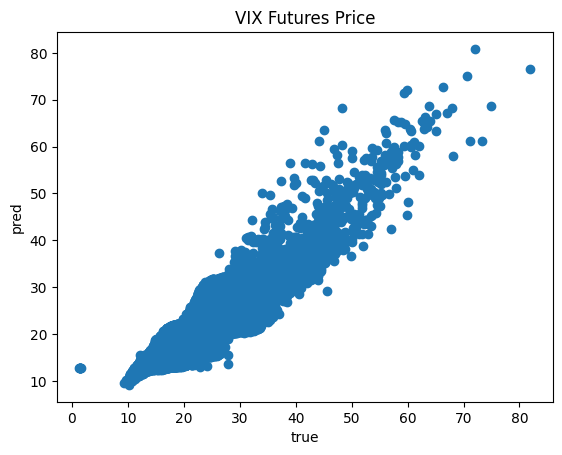

In [174]:
evaluate_by_range(df['Futures_Price'], df['CIR_Futures_Price'])
plot(df['Futures_Price'], df['CIR_Futures_Price'])

Range (0, inf):
count: 43716
mape: 12.28788681193064
rmse: 12.406243084033912
mae: 2.6853863108637976
-------------------
Range (0, 15):
count: 5827
mape: 6.795487907470759
rmse: 1.1431936346594627
mae: 0.7936104996346274
-------------------
Range (15, 30):
count: 34051
mape: 12.96373706037935
rmse: 11.493449723234756
mae: 2.7425975644976477
-------------------
Range (30, 45):
count: 3567
mape: 14.976578548074077
rmse: 37.30890890982547
mae: 5.045627463674297
-------------------
Range (45, inf):
count: 271
mape: 10.074854278857417
rmse: 41.49667433672205
mae: 5.107146688985896
-------------------


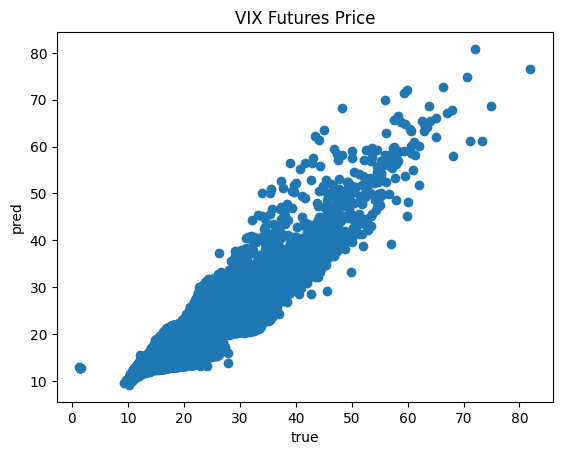

In [175]:
evaluate_by_range(df['Futures_Price'], df['CEV_Futures_Price'])
plot(df['Futures_Price'], df['CEV_Futures_Price'])

In [159]:
df.to_pickle('drive/MyDrive/VIX/df.pkl')

References
1. https://papers.ssrn.com/sol3/papers.cfm?abstract_id=3360713
2. https://rac.anpad.org.br/index.php/rac/article/view/1527/1778
3. https://github.com/dougransom/vix_utils